In [2]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cpu


# Make train and valid datasets

These two cells only need to be run once (the second one takes a very long time).

In [4]:
train_file_list = './data/BALLROOM/BallroomData/train_files.txt'
valid_file_list = './data/BALLROOM/BallroomData/valid_files.txt'

datasets_path  = './data/saved-datasets/ballroom/'
if not os.path.exists(datasets_path):
    os.makedirs(datasets_path)

audio_files = open('./data/BALLROOM/BallroomData/allBallroomFiles').readlines()
L = 6 #len(audio_files)

p = 0.8
N = int(p * L)
idxs = np.random.permutation(L)
train_audio_files = [audio_files[i] for i in idxs[:N]]
valid_audio_files = [audio_files[i] for i in idxs[N:]]
with open(train_file_list, 'w') as f:
    f.writelines(train_audio_files)
with open(valid_file_list, 'w') as f:
    f.writelines(valid_audio_files)
    
validset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/valid/',
                                        'valid_files.txt', force_nb_samples=3)
validset.save(datasets_path + 'valid.ab')

plain_trainset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/train/plain/',
                                              'train_files.txt', force_nb_samples=3)
plain_trainset.save(datasets_path + 'plain-train.ab')

augme_trainset = beatfinder.datasets.BALLROOM('./data/precomputations/ballroom/train/augmented/',
                                              'train_files.txt', force_nb_samples=3)
augme_trainset.augment()
augme_trainset.save(datasets_path + 'augme-train.ab')

trainset = plain_trainset + augme_trainset
trainset.save(datasets_path + 'train.ab')

print(f'Train size: {len(trainset)}')
print(f'Valid size: {len(validset)}')

Train size: 24
Valid size: 6


In [6]:
print('trainset')
trainset.precompute()
print('validset')
validset.precompute()

trainset
100.00% | ETA: 0:00:00 | Media-103515.002                    validset
100.00% | ETA: 0:00:00 | Media-103611.002                    

# Load train and valid datasets

In [7]:
trainset = beatfinder.datasets.AudioBeatsDataset(file=datasets_path + 'train.ab')
validset = beatfinder.datasets.AudioBeatsDataset(file=datasets_path + 'valid.ab')

# Check examples

23/24
Stretch: 0.8356
 Offset: 5.5568


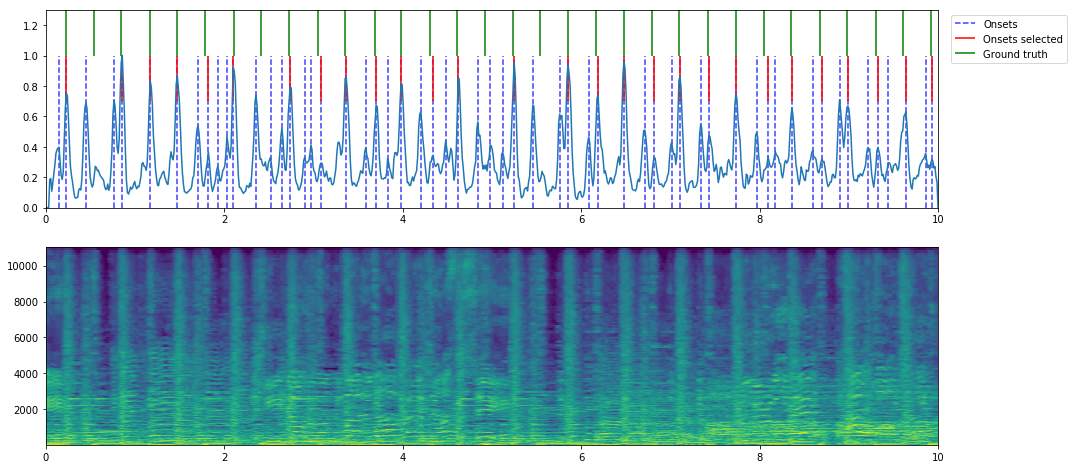

In [14]:
i = np.random.randint(len(trainset))
print(f'{i}/{len(trainset)}')
audiobeats = trainset[i]
print(f'Stretch: {audiobeats.stretch:.4f}')
print(f' Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

F measure: 1.00


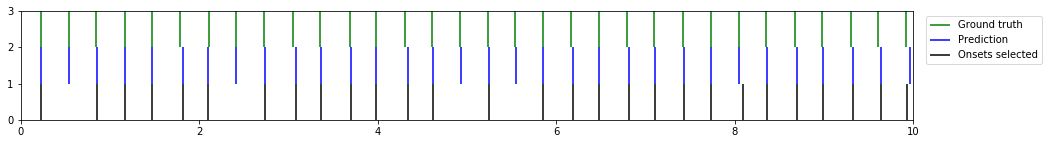

In [15]:
spec, onsets, isbeat, beats = audiobeats.get_data()
onsets_selected = beatfinder.utils.onsets_selected(onsets, isbeat)
pred_beats, bpm = beatfinder.utils.beat_track(onsets_selected)
beatfinder.display.showprediction(beats, pred_beats, onsets_selected)
print(f'F measure: {beatfinder.utils.F_measure(beats, pred_beats):.2f}')

# Setup datasets for pytorch

In [16]:
totensor = beatfinder.model.ToTensor(device)
trainset.transform = totensor
validset.transform = totensor

# Find learning rate

In [17]:
model = beatfinder.model.BeatFinder()
model.to(device)

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

In [18]:
dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

6 mini batches


In [19]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}')

1/6
2/6
3/6
4/6
5/6
6/6


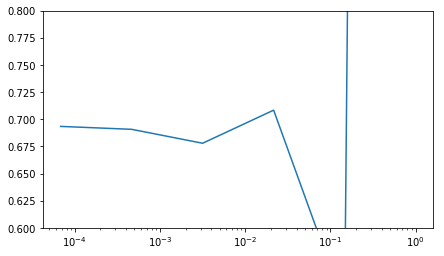

In [20]:
plt.figure(figsize=(7, 4))
plt.ylim(0.6, 0.8)
plt.semilogx(lr, losses);

# Train

In [21]:
model = beatfinder.model.BeatFinder()
model.to(device)
model.set_lr(0.0005)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [22]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:   0 | fp:   0 |
| fn: 150 | tn: 190 |
 -------------------
 Accuracy: 0.5588
Precision: nan
   Recall: nan
F-measure: nan
     Loss: 0.6892


In [23]:
model.unfreeze()
model.train();

In [24]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=4, epochs=2)

| 1 | TL: 0.656 | VL: 0.720 | TF: 0.244 | VF: 0.469 | TA: 0.607 | VA: 0.521 | 6.93 s/b | 0:00:41 | ETA: 0:00:41 |
| 2 | TL: 0.576 | VL: 0.692 | TF: 0.682 | VF: 0.559 | TA: 0.710 | VA: 0.597 | 6.97 s/b | 0:00:41 | ETA: 0:00:00 |


In [ ]:
# torch.save(model.state_dict(), './data/model_09.pt')

In [ ]:
model.eval()
model.freeze()

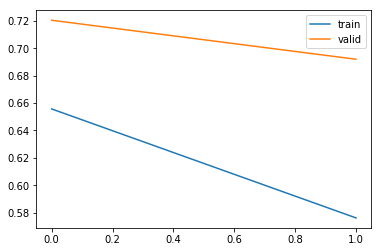

In [25]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.legend();

In [26]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:  85 | fp:  74 |
| fn:  65 | tn: 116 |
 -------------------
 Accuracy: 0.5912
Precision: 0.5346
   Recall: 0.5667
F-measure: 0.5502
     Loss: 0.6909


# Import saved model

In [ ]:
# model = beatfinder.model.BeatFinder()
# model.load_state_dict(torch.load('./data/pretrained-models/model_07.pt', map_location=device))
# model.eval()
# model.freeze()

# Look at an example of a prediction

In [33]:
dataset = trainset
dataset.transform = None

9/24


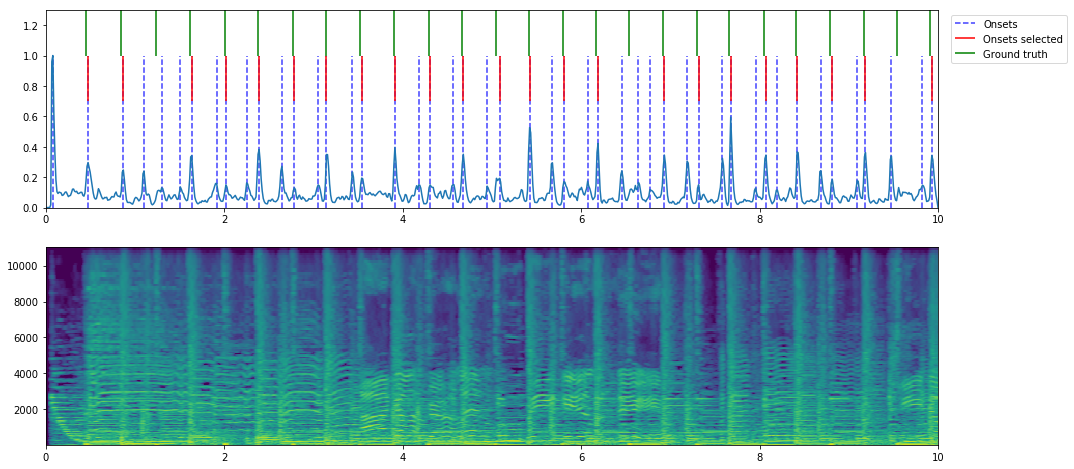

In [34]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
beatfinder.display.showdata(audiobeats)

F measure: 0.98


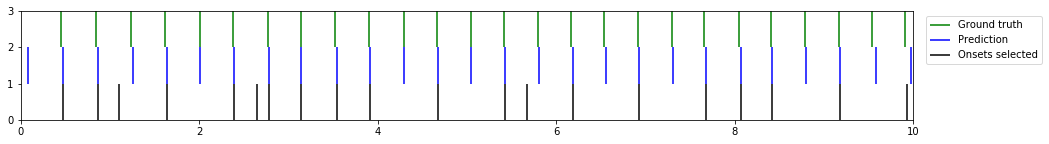

In [38]:
onsets_selected, beats_pred, bpm = beatfinder.utils.predict_beats(model, audiobeats, totensor)
beats = audiobeats.get_beats()
beatfinder.display.showprediction(beats, beats_pred, onsets_selected)
F = beatfinder.utils.F_measure(beats, beats_pred)
if F != None:
    print(f'F measure: {F:.2f}')
else:
    print('F measure: NaN')

# Evaluate a dataset

In [32]:
F, F_nan = beatfinder.utils.F_measure_from_dataset(model, dataset, totensor)
print()
print(f'F measure: {F:.2f}')
print(f'     NaNs: {F_nan}')

 0 : 0.46 |  1 : 0.61 |  2 : 0.44 |  3 : 0.65 |  4 : 0.67 |  5 : 0.49 | 
F measure: 0.55
     NaNs: 0
